<a href="https://colab.research.google.com/github/OliviaLiu417/EmailClassfication/blob/vera/Copy_1_of_vioviov_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import all the packages needed 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn import metrics


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving completeSpamAssassin.csv to completeSpamAssassin (2).csv


In [ ]:
# loading the dataset
import io
df = pd.read_csv(io.BytesIO(uploaded['completeSpamAssassin.csv']))
df.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1



# Step 1. Data exploration and preprocessing

In [ ]:
# print the basic information about the dataset for reference
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


In [ ]:
# dropping the redundant column
df.drop(['Unnamed: 0'],axis=1, inplace=True)

In [ ]:
# check for number of duplicates
print("Number of duplicates: ", df.duplicated().sum())
# check for number of null values
print("Number of null values: \n", df.isnull().sum())

Number of duplicates:  752
Number of null values: 
 Body     1
Label    0
dtype: int64


In [ ]:
# dropping null values
df.dropna(inplace=True)
# TODO: Remove duplicates?
df.drop_duplicates(inplace=True)

In [ ]:
def text_preprocessing_str(text):
    # convert  text to lowercase
    text = text.lower()
    
    # tokenize the text by creating a list of words 
    tokens = nltk.word_tokenize(text)
    
    # remove special charecters
    tokens_clean = [token for token in tokens if token.isalnum()]
    
    # remove stopwords and punctuation marks
    stop_words = set(stopwords.words('english')) 
    punctuation = set(string.punctuation)
    tokens_clean = [token for token in tokens_clean if token not in stop_words and token not in punctuation]

    # apply stemming to each word in the list
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(token) for token in tokens_clean]
        
    return " ".join(stemmed_tokens)

df['tokens_str'] = df['Body'].apply(text_preprocessing_str)
df

,Body,Label,tokens_str
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,save 70 life insur spend life quot save ensur ...
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,1 fight risk cancer http slim guarante lose lb...
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,1 fight risk cancer http slim guarante lose lb...
3,##############################################...,1,adult club offer free membership instant acces...
4,I thought you might like these:\n1) Slim Down ...,1,thought might like 1 slim guarante lose lbs 30...
...,...,...,...
6033,----------------------------------------------...,0,isilo tm palm os pocket pc window enter beta1 ...
6034,"EFFector Vol. 15, No. 35 November ...",0,effector vol 15 35 novemb 8 2002 ren public el...
6039,\nWe have extended our Free seat sale until Th...,0,extend free seat sale thursday 21st novemb det...
6042,___ ___ ...,0,insignific matter heavili overemphasis hugh mt...


In [ ]:
def text_preprocessing(text):
    # convert  text to lowercase
    text = text.lower()
    
    # tokenize the text by creating a list of words 
    tokens = nltk.word_tokenize(text)
    
    # remove special charecters
    tokens_clean = [token for token in tokens if token.isalnum()]
    
    # remove stopwords and punctuation marks
    stop_words = set(stopwords.words('english')) 
    punctuation = set(string.punctuation)
    tokens_clean = [token for token in tokens_clean if token not in stop_words and token not in punctuation]

    # apply stemming to each word in the list
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(token) for token in tokens_clean]
        
    return stemmed_tokens

df['tokens'] = df['Body'].apply(text_preprocessing)
df

,Body,Label,tokens_str,tokens
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,save 70 life insur spend life quot save ensur ...,"[save, 70, life, insur, spend, life, quot, sav..."
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,1 fight risk cancer http slim guarante lose lb...,"[1, fight, risk, cancer, http, slim, guarante,..."
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,1 fight risk cancer http slim guarante lose lb...,"[1, fight, risk, cancer, http, slim, guarante,..."
3,##############################################...,1,adult club offer free membership instant acces...,"[adult, club, offer, free, membership, instant..."
4,I thought you might like these:\n1) Slim Down ...,1,thought might like 1 slim guarante lose lbs 30...,"[thought, might, like, 1, slim, guarante, lose..."
...,...,...,...,...
6033,----------------------------------------------...,0,isilo tm palm os pocket pc window enter beta1 ...,"[isilo, tm, palm, os, pocket, pc, window, ente..."
6034,"EFFector Vol. 15, No. 35 November ...",0,effector vol 15 35 novemb 8 2002 ren public el...,"[effector, vol, 15, 35, novemb, 8, 2002, ren, ..."
6039,\nWe have extended our Free seat sale until Th...,0,extend free seat sale thursday 21st novemb det...,"[extend, free, seat, sale, thursday, 21st, nov..."
6042,___ ___ ...,0,insignific matter heavili overemphasis hugh mt...,"[insignific, matter, heavili, overemphasis, hu..."


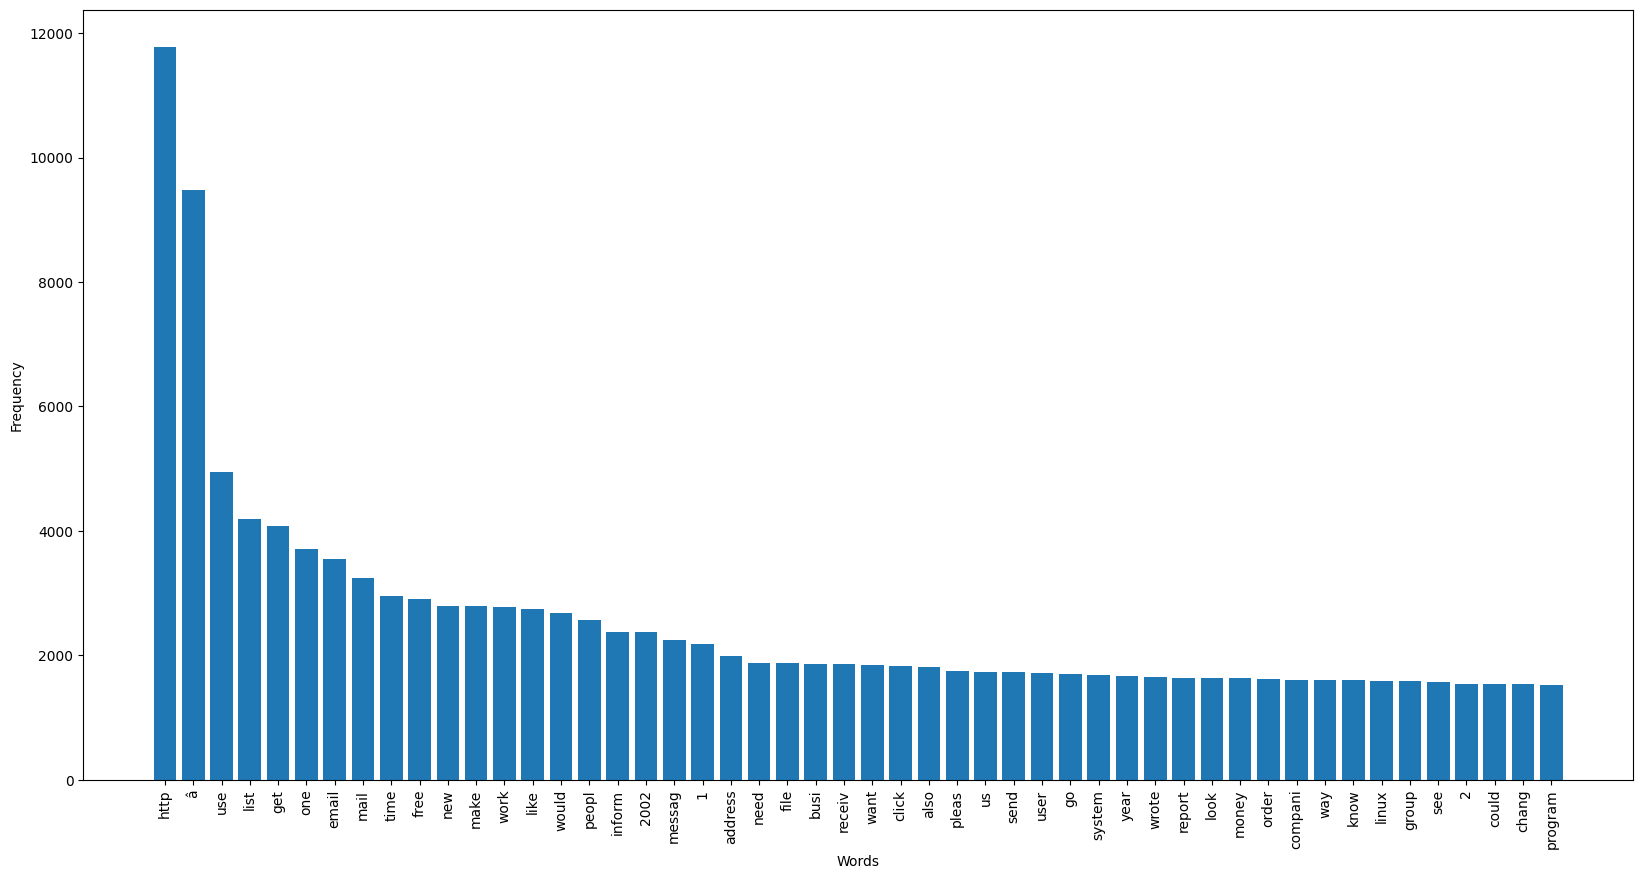

In [ ]:
#TODO: Bar graphs for both spam and ham emails?
all_lists = df['tokens'];
all_tokens = [word for sample in all_lists for word in sample]

def draw_frequency(words):
  # Assuming word_freq is a dictionary containing the frequency of each word
  word_freq = Counter(words)

  # Get the 20 most common words and their frequencies
  most_common = word_freq.most_common(50)

  # Extract the words and frequencies into separate lists
  words = [pair[0] for pair in most_common]
  freqs = [pair[1] for pair in most_common]

  # Create a bar graph of the word frequencies
  plt.figure(figsize=(20, 10))
  plt.xticks(rotation='vertical')
  plt.bar(words, freqs)
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.show()
  return 

draw_frequency(all_tokens)

In [ ]:
#Changing text data in to numbers.

# tfidf = TfidfVectorizer()
tfidf = TfidfVectorizer(max_features=17000)



# Setting up features and target as x and y
x = tfidf.fit_transform(df['tokens_str']).toarray()
y = df['Label'].values

In [ ]:
# Splitting the testing and training sets
x_train1,x_test1,y_train1,y_test1 = train_test_split(x,y,test_size=0.2,random_state=0)

Maximum accuracy:- 0.9650613786591123 at K = 28


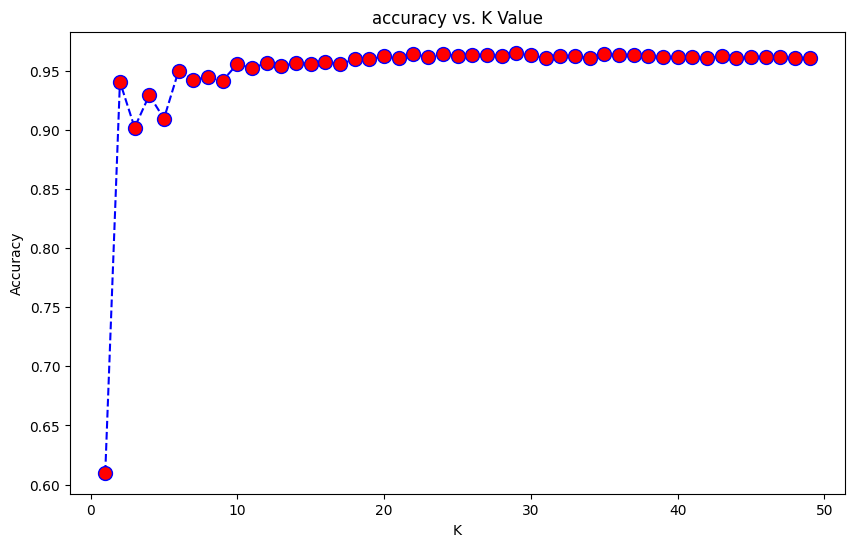

In [14]:
# find the optimal number of k
# Will take some time
#acc = []
#for i in range(1,50):
#    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train1,y_train1)
#    yhat = neigh.predict(x_test1)
#    acc.append(metrics.accuracy_score(y_test1, yhat))
#    
#plt.figure(figsize=(10,6))
#plt.plot(range(1,50),acc,color = 'blue',linestyle='dashed', 
#         marker='o',markerfacecolor='red', markersize=10)
#plt.title('accuracy vs. K Value')
#plt.xlabel('K')
#plt.ylabel('Accuracy')
#print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

Minimum error:- 0.03493862134088763 at K = 28


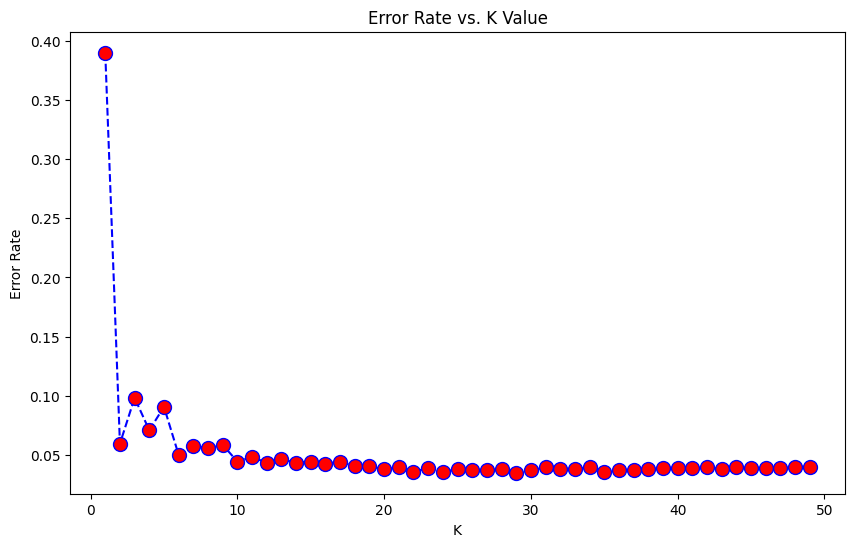

In [15]:
#error_rate = []
#for i in range(1,50):
#  knn = KNeighborsClassifier(n_neighbors=i)
#  knn.fit(x_train1,y_train1)
#  pred_i = knn.predict(x_test1)
#  error_rate.append(np.mean(pred_i != y_test1))
#  i+=10

#plt.figure(figsize=(10,6))
#plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
#         marker='o',markerfacecolor='red', markersize=10)
#plt.title('Error Rate vs. K Value')
#plt.xlabel('K')
#plt.ylabel('Error Rate')
#print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [16]:
gnb = GaussianNB()
svc = SVC(kernel='sigmoid', gamma=1.0)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
knn = KNeighborsClassifier(n_neighbors=28)

In [17]:
classifiers = {
    'GaussianNB' : gnb,
    'SVC' : svc,
    'LogisticRegression': lrc,
    'KNearestNeighbor': knn,
}

In [18]:
# creating a function to train list of algorithms and give accuracy, precision score, and time
def train_classifier(classifiers,x_train,y_train,x_test,y_test):
    
    t0 = time.time()
    classifiers.fit(x_train,y_train)
    training_time = time.time()-t0

    t1 = time.time()
    y_pred = classifiers.predict(x_test)
    prediction_time = time.time()-t1

    # accuracy = accuracy_score(y_test,y_pred)
    accuracy = cross_val_score(classifiers, x_train, y_train, cv=5, scoring='accuracy')
    # precision = precision_score(y_test,y_pred)
    precision = cross_val_score(classifiers, x_train, y_train, cv=5, scoring='precision')
    
    return accuracy,precision,training_time,prediction_time

In [19]:
# storing accuracy and precision in list
accuracy_scores1 = []
precision_scores1 = []
training_time1 = []
prediction_time1 = []

# training all the models on training data
for name,classifier in classifiers.items():
    
    current_accuracy1,current_precision1, training_t1, prediction_t1 = train_classifier(classifier, x_train1,y_train1,x_test1,y_test1)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy1)
    print("Precision - ",current_precision1)
    print("Training Time -", training_t1)
    print("Prediction Time", prediction_t1, '\n')
    
    accuracy_scores1.append(current_accuracy1)
    precision_scores1.append(current_precision1)
    training_time1.append(training_t1)
    prediction_time1.append(prediction_t1)

For  GaussianNB
Accuracy -  [0.91735537 0.93152302 0.905549   0.93978749 0.91725768]
Precision -  [0.85714286 0.88942308 0.87301587 0.91262136 0.88265306]
Training Time - 1.698319435119629
Prediction Time 0.2767605781555176 

For  SVC
Accuracy -  [0.98229044 0.98819362 0.97638725 0.98937426 0.9787234 ]
Precision -  [0.98122066 0.99528302 0.98086124 0.9953271  0.98095238]
Training Time - 59.26038217544556
Prediction Time 14.789313554763794 

For  LogisticRegression
Accuracy -  [0.94451004 0.95159386 0.95749705 0.96812279 0.95981087]
Precision -  [0.94818653 0.97354497 0.96954315 0.98019802 0.96969697]
Training Time - 0.4703190326690674
Prediction Time 0.034215688705444336 

For  KNearestNeighbor
Accuracy -  [0.96103896 0.97284534 0.95867769 0.96340024 0.95744681]
Precision -  [0.93896714 0.95813953 0.91891892 0.93577982 0.90350877]
Training Time - 0.06232929229736328
Prediction Time 6.964576482772827 



In [20]:
# performance table
performance1 = pd.DataFrame({'Algorithm': classifiers.keys(),'Accuracy':np.mean(np.array(accuracy_scores1), axis=1),'Precision':np.mean(np.array(precision_scores1), axis=1)})# .sort_values('Precision',ascending=False)
performance1

,Algorithm,Accuracy,Precision
0,GaussianNB,0.922295,0.882971
1,SVC,0.982994,0.986729
2,LogisticRegression,0.956307,0.968234
3,KNearestNeighbor,0.962682,0.931063


In [21]:
# performance table based on the training time
performance1_time = pd.DataFrame({'Algorithm': classifiers.keys(), 'Training Time (s)': training_time1, "Prediction Time (s)":prediction_time1})
performance1_time

,Algorithm,Training Time (s),Prediction Time (s)
0,GaussianNB,1.698319,0.276761
1,SVC,59.260382,14.789314
2,LogisticRegression,0.470319,0.034216
3,KNearestNeighbor,0.062329,6.964576


In [22]:
# Using binary encoding instead of tf-idf
binary_vectorizer = TfidfVectorizer(binary=True, norm=None, use_idf=False, smooth_idf=False, lowercase=True, min_df=1, max_df=1.0, max_features=17000, ngram_range=(1,1))

# Setting up features and target as x and y
x_binary = binary_vectorizer.fit_transform(df['tokens_str']).toarray()
y_binary = df['Label'].values

In [23]:
# Splitting the testing and training sets
x_train2,x_test2,y_train2,y_test2 = train_test_split(x_binary,y_binary,test_size=0.2,random_state=0)

In [24]:
# storing accuracy and precision in list
accuracy_scores2 = [] 
precision_scores2 = []
training_time2 = []
prediction_time2 = []

# training all the models on training data
for name,classifier in classifiers.items():
    
    current_accuracy2,current_precision2,training_t2,prediction_t2 = train_classifier(classifier, x_train2,y_train2, x_test2,y_test2)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy2)
    print("Precision - ",current_precision2)
    print("Training Time -", training_t2)
    print("Prediction Time -", prediction_t2, '\n')

    
    accuracy_scores2.append(current_accuracy2)
    precision_scores2.append(current_precision2)
    training_time2.append(training_t2)
    prediction_time2.append(prediction_t2)

For  GaussianNB
Accuracy -  [0.91617473 0.93152302 0.90436836 0.92798111 0.91725768]
Precision -  [0.84331797 0.88571429 0.86082474 0.87383178 0.86764706]
Training Time - 1.495584487915039
Prediction Time - 0.27295899391174316 

For  SVC
Accuracy -  [0.66706021 0.69775679 0.69657615 0.69539551 0.68439716]
Precision -  [0.37190083 0.41089109 0.41       0.41777778 0.38967136]
Training Time - 82.04181957244873
Prediction Time - 19.20585536956787 

For  LogisticRegression
Accuracy -  [0.96694215 0.97520661 0.97874852 0.97874852 0.97635934]
Precision -  [0.95714286 0.97156398 0.96774194 0.96774194 0.95454545]
Training Time - 0.815910816192627
Prediction Time - 0.04957699775695801 

For  KNearestNeighbor
Accuracy -  [0.82644628 0.87485242 0.85950413 0.86422668 0.84160757]
Precision -  [0.84761905 0.84756098 0.73831776 0.74766355 0.66929134]
Training Time - 0.0745854377746582
Prediction Time - 6.046401023864746 



In [25]:
# performance table
performance2 = pd.DataFrame({'Algorithm': classifiers.keys(),'Accuracy':np.mean(np.array(accuracy_scores2), axis=1),'Precision':np.mean(np.array(precision_scores2), axis=1)})# .sort_values('Precision',ascending=False)
performance2

,Algorithm,Accuracy,Precision
0,GaussianNB,0.919461,0.866267
1,SVC,0.688237,0.400048
2,LogisticRegression,0.975201,0.963747
3,KNearestNeighbor,0.853327,0.770091


In [26]:
# performance table based on the training time
performance2_time = pd.DataFrame({'Algorithm': classifiers.keys(), 'Training Time (s)': training_time2, "Prediction Time (s)": prediction_time2})
performance2_time

,Algorithm,Training Time (s),Prediction Time (s)
0,GaussianNB,1.495584,0.272959
1,SVC,82.041820,19.205855
2,LogisticRegression,0.815911,0.049577
3,KNearestNeighbor,0.074585,6.046401


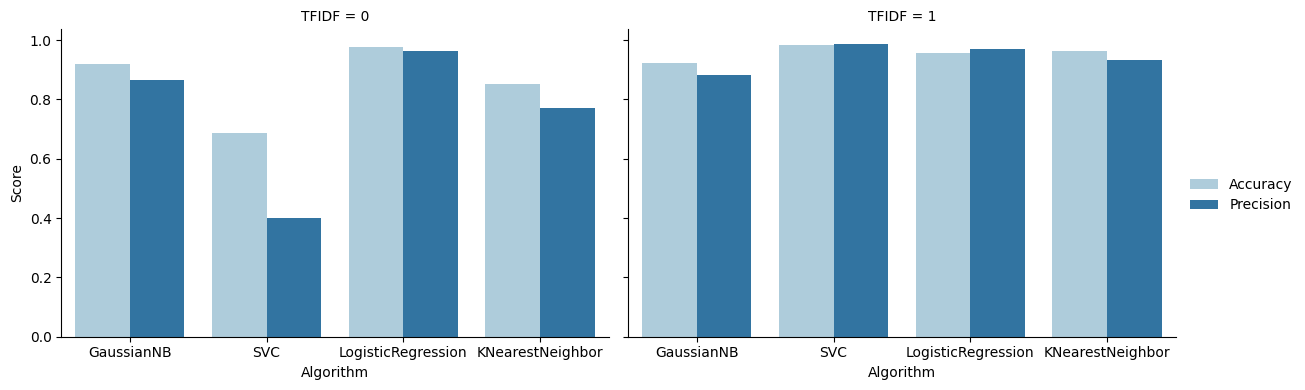

In [27]:
# plot performance

perform1_df = pd.melt(performance1, id_vars="Algorithm", var_name="Metric", value_name="Score")
perform1_df['TFIDF'] = 1
# print(perform1_df)

perform2_df = pd.melt(performance2, id_vars="Algorithm", var_name="Metric", value_name="Score")
perform2_df['TFIDF'] = 0
# print(perform2_df)

perform_df = pd.concat([perform1_df, perform2_df])
g = sns.FacetGrid(perform_df, col='TFIDF', height=4, aspect=1.5)
g.map_dataframe(sns.barplot, x="Algorithm", y="Score", hue="Metric", palette="Paired")
g.add_legend()